In [2]:
import os
import time
import sys
sys.path.append('..')  # Add parent folder to sys.path

import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from data_sample import generate_example_data as data
from core.kernel import ARDKernel
import core.GP_CommonCalculation as GP
# from torch.autograd import Variable
import torch.optim as optim
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# generate example data
xtr, ytr,xte,yte = data.generate(2000,100,seed=42)
xtr = xtr.to(dtype=torch.float64,device=device)
ytr = ytr.to(dtype=torch.float64, device=device)
xte = xte.to(dtype=torch.float64,device=device)

In [4]:
kernel= ARDKernel(1)

In [5]:
log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64, device=device) * -4)

In [6]:
def negative_log_likelihood(xtr, ytr, kernel,log_beta):
    n = xtr.shape[0]
    Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(xtr.size(0), device=device)

    return -GP.Gaussian_log_likelihood(ytr,Sigma,Kinv_method='conjugate')

In [7]:
def forward(xtr, ytr, xte, kernel,log_beta):

    Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(xtr.size(0), device=device)

    K_s = kernel(xtr, xte)
    K_ss=kernel(xte,xte)
    mean,var=GP.conditional_Gaussian(ytr,Sigma,K_s,K_ss,Kinv_method="conjugate")
    var_diag=var.sum(dim = 0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)


    return mean,var_diag

In [8]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [9]:
train_adam(xtr, ytr, kernel, log_beta, niteration=100,lr=0.1)

iter 0 nll:382502.06290
iter 1 nll:299551.12541
iter 2 nll:220919.77021
iter 3 nll:156796.60055
iter 4 nll:113465.22244
iter 5 nll:87426.06698
iter 6 nll:71500.41040
iter 7 nll:60641.16830
iter 8 nll:52378.21319
iter 9 nll:45658.33479
iter 10 nll:40023.15320
iter 11 nll:35127.48869
iter 12 nll:30611.39181
iter 13 nll:26281.49448
iter 14 nll:22253.33022
iter 15 nll:18817.27484
iter 16 nll:16142.44942
iter 17 nll:14162.87250
iter 18 nll:12704.92916
iter 19 nll:11613.04566
iter 20 nll:10776.21731
iter 21 nll:10115.66322
iter 22 nll:9575.73884
iter 23 nll:9119.04415
iter 24 nll:8721.72755
iter 25 nll:8368.84263
iter 26 nll:8050.87485
iter 27 nll:7761.44815
iter 28 nll:7496.04140
iter 29 nll:7251.27441
iter 30 nll:7024.50625
iter 31 nll:6813.60053
iter 32 nll:6616.78275
iter 33 nll:6432.54961
iter 34 nll:6259.61008
iter 35 nll:6096.84465
iter 36 nll:5943.27521
iter 37 nll:5798.04295
iter 38 nll:5660.39018
iter 39 nll:5529.64619
iter 40 nll:5405.21513
iter 41 nll:5286.56598
iter 42 nll:5173.

In [10]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel,log_beta)

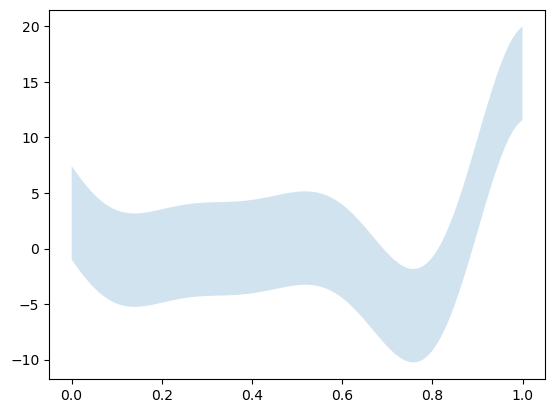

In [11]:
plt.fill_between(xte.cpu().squeeze().numpy(), ypred.cpu().squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.cpu().squeeze().detach().numpy()), ypred.cpu().squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.cpu().squeeze().detach().numpy()), alpha=0.2, label='95% Confidence interval')
#plt.plot(xtr.cpu().numpy(), ytr.cpu().numpy(), 'b+')
plt.show()